In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import warnings

from src.pdb_to_dfs import process_pdb

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


**Protein-ssDNA**: Use the center of mass coordinates of base (B). {Use `DA`, `DT`, `DG`, and `DC` for different nucleotides} and C-alpha or Center of mass of side chain for the calculations. 
1. Calculate the distance between Base (B) and the nearest C-alpha atom of protein.
2. Calculate the distance between Base (B) and the nearest side chain (use COM). 
3. Calculate the distance between Base (B) and any nearest atom of protein (either C-alpha or side chain of protein).

In [2]:
pdbs_folder = "data/processed_pdbs"
pdb_list = [pdb for pdb in os.listdir(pdbs_folder) if pdb.endswith(".pdb")]

In [3]:
pdb_name = pdb_list[10]
dfs, chain_types = process_pdb(pdb_name, pdbs_folder)

dfs_ssdna = [df for df, chain_type in zip(dfs, chain_types) if chain_type == "ssdna"]
dfs_ssdna = pd.concat(dfs_ssdna)

dfs_protein = [df for df, chain_type in zip(dfs, chain_types) if chain_type == "protein"]
dfs_protein = pd.concat(dfs_protein)

Nucleotide 9 in chain B has missing atoms.


In [4]:
dfs_protein.head()

,residue,ca_coords,sidechain_coms
0,GLN,"[39.903, 18.827, -17.926]","[39.814003, 21.0476, -20.413998]"
1,TYR,"[38.815, 15.201, -18.075]","[38.876873, 15.96775, -21.649626]"
2,HIS,"[37.221, 12.597, -15.85]","[35.48567, 10.136167, -15.092168]"
3,VAL,"[35.88, 13.397, -12.405]","[34.08067, 13.036667, -11.783333]"
4,GLU,"[37.669, 14.133, -9.12]","[38.597603, 15.357, -6.7226]"


Columns in protein df: ['residue', 'ca_coords', 'sidechain_coms']

In [6]:
dfs_ssdna.head()

,residue,sugar_com,base_com,phosphate_com
0,DC,"[31.66825, 42.730255, 8.845875]","[31.704876, 40.248123, 12.269251]","[35.831005, 43.051666, 10.074667]"
1,DC,"[26.24175, 45.035625, 4.273375]","[23.182625, 44.714127, 0.455]","[29.695, 42.822998, 5.7643332]"


Columns in ssDNA df: ['residue', 'sugar_com', 'base_com', 'phosphate_com']

In [9]:
# For each residue in ssdna chain, find the closest residue in protein chain, 
# based on closest distance between CA atoms and base com.
for i, row in dfs_ssdna.iterrows():
    base_com = row["base_com"]
    closest_residue_ca_index = dfs_protein["ca_coords"].apply(lambda x: np.linalg.norm(x - base_com)).idxmin()
    closest_residue_ca_distance = np.linalg.norm(dfs_protein.loc[closest_residue_ca_index, "ca_coords"] - base_com)

    closest_residue_sidechain_index = dfs_protein["sidechain_coms"].dropna().apply(lambda x: np.linalg.norm(x - base_com)).idxmin()
    closest_residue_sidechain_distance = np.linalg.norm(dfs_protein.loc[closest_residue_sidechain_index, "sidechain_coms"] - base_com)

    # Add the closest residue to the ssdna dataframe
    dfs_ssdna.loc[i, "closest_residue_ca_index"] = closest_residue_ca_index
    dfs_ssdna.loc[i, "closest_residue_ca_distance"] = closest_residue_ca_distance

    dfs_ssdna.loc[i, "closest_residue_sidechain_index"] = closest_residue_sidechain_index
    dfs_ssdna.loc[i, "closest_residue_sidechain_distance"] = closest_residue_sidechain_distance

In [10]:
print(f"Closest residue to {row['residue']} is {dfs_protein.loc[closest_residue_ca_index, 'residue']} with distance {closest_residue_ca_distance:.2f}")
print(f"Indices: {i}, {closest_residue_ca_index}")

Closest residue to DC is PRO with distance 10.16
Indices: 1, 62


In [16]:
print(f"Closest residue to {row['residue']} is {dfs_protein.loc[closest_residue_sidechain_index, 'residue']} with distance {closest_residue_sidechain_distance:.2f}")
print(f"Indices: {i}, {closest_residue_sidechain_index}")

Closest residue to DC is ILE with distance 9.48
Indices: 1, 60


In [11]:
dfs_ssdna["closest_residue_ca_index"] = dfs_ssdna["closest_residue_ca_index"].astype(int)
dfs_ssdna["closest_residue_sidechain_index"] = dfs_ssdna["closest_residue_sidechain_index"].astype(int)

dfs_ssdna.head()

,residue,sugar_com,base_com,phosphate_com,closest_residue_ca_index,closest_residue_ca_distance,closest_residue_sidechain_index,closest_residue_sidechain_distance
0,DC,"[31.66825, 42.730255, 8.845875]","[31.704876, 40.248123, 12.269251]","[35.831005, 43.051666, 10.074667]",115,7.158820,115,6.094775
1,DC,"[26.24175, 45.035625, 4.273375]","[23.182625, 44.714127, 0.455]","[29.695, 42.822998, 5.7643332]",62,10.164877,60,9.480768


In [13]:
dfs_ssdna["closest_residue_distance"] = dfs_ssdna[["closest_residue_ca_distance", "closest_residue_sidechain_distance"]].min(axis=1)

In [14]:
dfs_ssdna.drop(["sugar_com", "base_com", "phosphate_com", "closest_residue_ca_index", "closest_residue_sidechain_index"], axis=1, inplace=True)
dfs_ssdna.head()

,residue,phosphate_com,closest_residue_ca_distance,closest_residue_sidechain_distance,closest_residue_distance
0,DC,"[35.831005, 43.051666, 10.074667]",7.158820,6.094775,6.094775
1,DC,"[29.695, 42.822998, 5.7643332]",10.164877,9.480768,9.480768


In [31]:
df_data = pd.DataFrame()
for pdb_name in pdb_list:
    try:
        dfs, chain_types = process_pdb(pdb_name, pdbs_folder)
    except:
        print(f"Error processing {pdb_name}")
        continue

    df_ssdna = [df for df, chain_type in zip(dfs, chain_types) if chain_type == "ssdna"]
    if len(df_ssdna) == 0:
        continue
    elif len(df_ssdna) > 1:
        df_ssdna = pd.concat(df_ssdna)
        df_ssdna.reset_index(inplace=True, drop=True)
    else:
        df_ssdna = df_ssdna[0]

    df_protein = [df for df, chain_type in zip(dfs, chain_types) if chain_type == "protein"]
    if len(df_protein) > 1:
        df_protein = pd.concat(df_protein)
        df_protein.reset_index(inplace=True, drop=True)
    else:
        df_protein = df_protein[0]

    for i, row in df_ssdna.iterrows():
        base_com = row["base_com"]
        closest_residue_ca_index = df_protein["ca_coords"].apply(lambda x: np.linalg.norm(x - base_com)).idxmin()
        closest_residue_ca_distance = np.linalg.norm(df_protein.loc[closest_residue_ca_index, "ca_coords"] - base_com)

        closest_residue_sidechain_index = df_protein["sidechain_coms"].dropna().apply(lambda x: np.linalg.norm(x - base_com)).idxmin()
        closest_residue_sidechain_distance = np.linalg.norm(df_protein.loc[closest_residue_sidechain_index, "sidechain_coms"] - base_com)

        df_ssdna.loc[i, "closest_residue_ca_distance"] = closest_residue_ca_distance
        df_ssdna.loc[i, "closest_residue_sidechain_distance"] = closest_residue_sidechain_distance


    df_ssdna["closest_residue_distance"] = df_ssdna[["closest_residue_ca_distance", "closest_residue_sidechain_distance"]].min(axis=1)

    df_ssdna.drop(["sugar_com", "base_com", "phosphate_com"], axis=1, inplace=True)

    # Concat to existing dataframe
    df_data = pd.concat([df_data, df_ssdna])

df_data.head()

Nucleotide 1 in chain B has missing atoms.
Nucleotide 1 in chain B has missing atoms.
Nucleotide 1 in chain B has missing atoms.
Nucleotide 9995 in chain B has missing atoms.
Nucleotide 9 in chain B has missing atoms.
Nucleotide 6 in chain C has missing atoms.
Nucleotide 15 in chain C has missing atoms.
Nucleotide 17 in chain C has missing atoms.
Nucleotide 18 in chain C has missing atoms.
Nucleotide 20 in chain C has missing atoms.
Nucleotide 25 in chain C has missing atoms.
Nucleotide 1 in chain B has missing atoms.
Nucleotide 1 in chain F has missing atoms.
Nucleotide 9 in chain G has missing atoms.
Nucleotide 1 in chain L has missing atoms.
Nucleotide 1 in chain H has missing atoms.
Nucleotide 1 in chain I has missing atoms.
Nucleotide 1 in chain C has missing atoms.
Nucleotide 1 in chain D has missing atoms.
Nucleotide 923 in chain C has missing atoms.
Nucleotide 935 in chain D has missing atoms.
Nucleotide 11 in chain D has missing atoms.
Nucleotide 1 in chain B has missing atoms

,residue,closest_residue_ca_distance,closest_residue_sidechain_distance,closest_residue_distance
0,DT,5.671150,3.488274,3.488274
1,DT,6.140086,3.536165,3.536165
2,DT,6.640112,3.820036,3.820036
0,DA,7.190639,5.342240,5.342240
1,5HC,5.418911,4.080000,4.080000


In [32]:
# Remove rows where the closest residue is not a nucleotide residue
df_data = df_data[df_data["residue"].isin(["DA", "DC", "DG", "DT"])]

In [35]:
df_data.columns = ['nu', 'closest_residue_ca_distance',
       'closest_residue_sidechain_distance', 'closest_residue_distance']

In [36]:
df_data.head()

,nu,closest_residue_ca_distance,closest_residue_sidechain_distance,closest_residue_distance
0,DT,5.671150,3.488274,3.488274
1,DT,6.140086,3.536165,3.536165
2,DT,6.640112,3.820036,3.820036
0,DA,7.190639,5.342240,5.342240
2,DA,5.056645,3.587384,3.587384


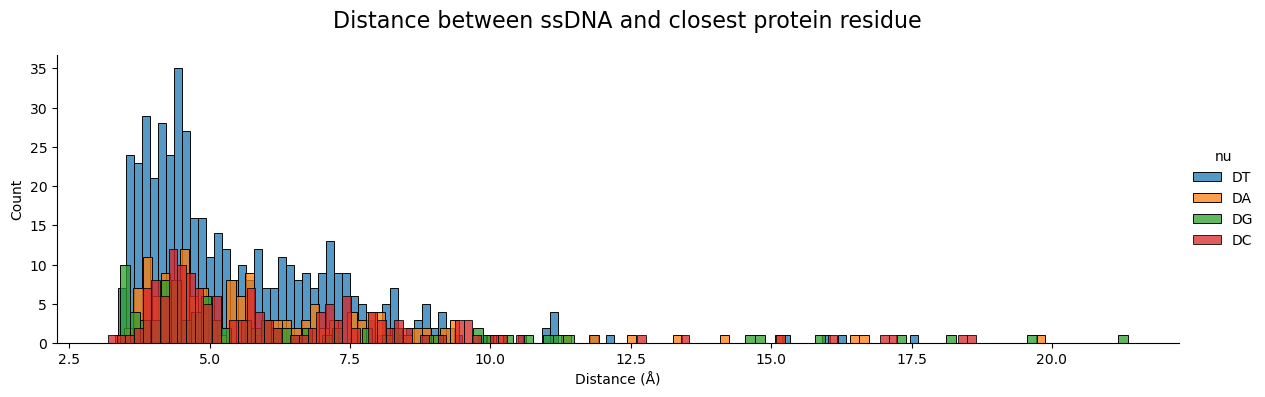

In [43]:
plot = sns.FacetGrid(data=df_data, hue="nu", height=5)
plot.figure.set_size_inches(12, 4)
plot.figure.suptitle("Distance between ssDNA and closest protein residue", fontsize=16)
plot.map(sns.histplot, "closest_residue_distance", bins=100)
plot.add_legend()
plot.set_axis_labels("Distance (Å)", "Count")
plot.savefig("ssdna_protein_distance.png", dpi=300)




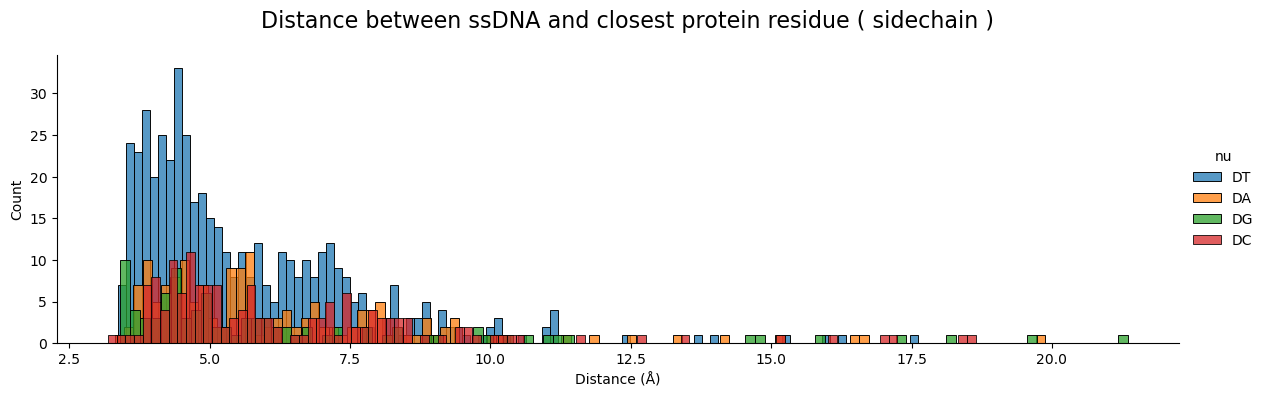

In [45]:
plot = sns.FacetGrid(data=df_data, hue="nu", height=5)
plot.figure.set_size_inches(12, 4)
plot.figure.suptitle("Distance between ssDNA and closest protein residue ( sidechain )", fontsize=16)
plot.map(sns.histplot, "closest_residue_sidechain_distance", bins=100)
plot.add_legend()
plot.set_axis_labels("Distance (Å)", "Count")
plot.savefig("ssdna_protein_distance.png", dpi=300)

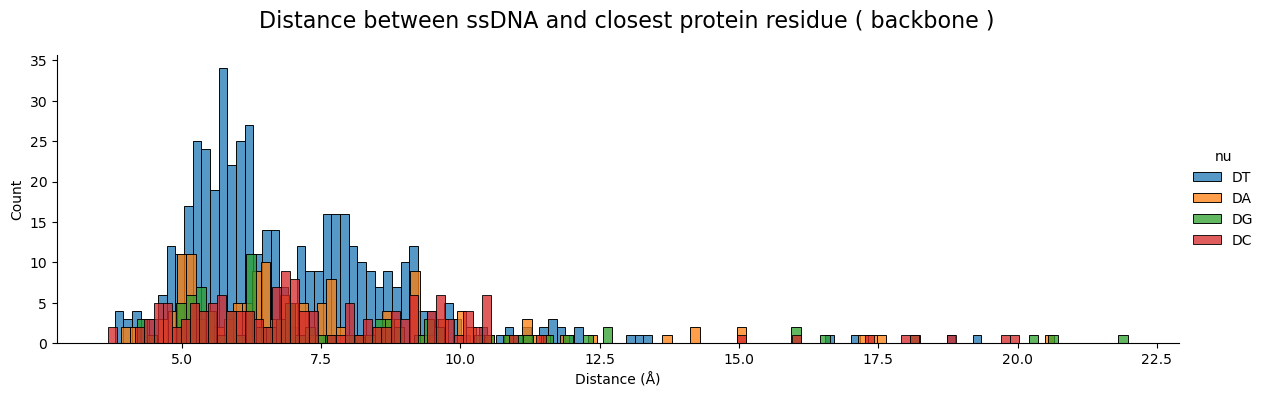

In [46]:
plot = sns.FacetGrid(data=df_data, hue="nu", height=5)
plot.figure.set_size_inches(12, 4)
plot.figure.suptitle("Distance between ssDNA and closest protein residue ( backbone )", fontsize=16)
plot.map(sns.histplot, "closest_residue_ca_distance", bins=100)
plot.add_legend()
plot.set_axis_labels("Distance (Å)", "Count")
plot.savefig("ssdna_protein_distance.png", dpi=300)